In [1]:
import sys, platform
print("PY:", sys.executable)
print("VER:", sys.version)

PY: /Users/jan/Documents/working papers/project 1/venv311/bin/python
VER: 3.11.13 (main, Jun  3 2025, 18:38:25) [Clang 17.0.0 (clang-1700.0.13.3)]


In [51]:

# pip install -U numpy pandas torch matplotlib

# Install TimesFM (Torch edition)
# pip install "timesfm[torch]"

# source venv311/bin/activate

In [2]:
import sys
from pathlib import Path

# Point to the project root (parent of "models" and "utils")
project_root = Path(__file__).resolve().parents[1] if "__file__" in globals() else Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

print("Project root:", project_root)

Project root: /Users/jan/Documents/working papers/project 1


In [3]:
#imports 
import os
import math
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

warnings.filterwarnings("ignore")

try:
    import torch
    TORCH_AVAILABLE = True
except Exception:
    TORCH_AVAILABLE = False

import timesfm

In [20]:
# config
CSV_PATH = str(Path("/Users/jan/Documents/working papers/project 1/data/btc_1h_test.csv"))  
TIME_COL = "timestamp"
TARGET_COL = "close"


#metrics for hyperparamerrization
CONTEXT_LENGTH = 512         # TimesFM-1.0 max context is 512
FORECAST_LENGTH = 96         # match TTM horizon; we will extract the first step
FREQ_STR = "1H"               # hourly
BATCH_SIZE = 64              # batch windows for speed
USE_LAST_N_POINTS_TO_PLOT = 1500  # plotting range

# Output
OUT_PRED_CSV = "timesfm_zeroshot_btc_predictions.csv"

In [21]:
# bacekend selection
def select_backend() -> str:
    """
    TimesFM wants 'cpu' or 'gpu'.
    We'll pick 'gpu' if CUDA or MPS is available in your torch build; otherwise 'cpu'.
    """
    if not TORCH_AVAILABLE:
        return "cpu"
    has_cuda = torch.cuda.is_available()
    has_mps = getattr(torch.backends, "mps", None) and torch.backends.mps.is_available()
    return "gpu" if (has_cuda or has_mps) else "cpu"

BACKEND = select_backend()

if TORCH_AVAILABLE and hasattr(torch, "set_float32_matmul_precision"):
    torch.set_float32_matmul_precision("high")

print(f"[TimesFM] backend='{BACKEND}', context={CONTEXT_LENGTH}, horizon={FORECAST_LENGTH}")


[TimesFM] backend='gpu', context=512, horizon=96


In [22]:
# Load and preprocessing
def load_btc_csv(csv_path: str, time_col: str, target_col: str) -> pd.DataFrame:
    df = pd.read_csv(csv_path)
    # Standardize columns
    if time_col not in df.columns or target_col not in df.columns:
        # Try common variants
        lower_cols = {c.lower(): c for c in df.columns}
        time_col = lower_cols.get(time_col.lower(), time_col)
        target_col = lower_cols.get(target_col.lower(), target_col)

    df = df[[time_col, target_col]].copy()
    df[time_col] = pd.to_datetime(df[time_col], utc=False)
    df = df.sort_values(time_col).reset_index(drop=True)

    # Convert to float
    df[target_col] = pd.to_numeric(df[target_col], errors="coerce")
    df = df.dropna().reset_index(drop=True)
    return df

df = load_btc_csv(CSV_PATH, TIME_COL, TARGET_COL)
print(df.head(3))
print(f"Loaded {len(df)} rows from {CSV_PATH}")


            timestamp     close
0 2018-01-01 00:00:00  13949.61
1 2018-01-01 01:00:00  14111.28
2 2018-01-01 02:00:00  13977.47
Loaded 10000 rows from /Users/jan/Documents/working papers/project 1/data/btc_1h_test.csv


In [7]:
# Build TimesFM (smallest released: 1.0-200m, PyTorch)
# https://huggingface.co/google/timesfm-1.0-200m-pytorch
# context_len is fixed for 1.0; horizon_len is what is being requested per call.
tfm = timesfm.TimesFm(
    hparams=timesfm.TimesFmHparams(
        backend=BACKEND,              
        per_core_batch_size=BATCH_SIZE,
        horizon_len=FORECAST_LENGTH,
    ),
    checkpoint=timesfm.TimesFmCheckpoint(
        huggingface_repo_id="google/timesfm-1.0-200m-pytorch"
    ),
)

AttributeError: module 'timesfm' has no attribute 'TimesFm'

In [23]:
import sys, timesfm
print("PY:", sys.executable)
print("timesfm file:", getattr(timesfm, "__file__", "unknown"))
print("version:", getattr(timesfm, "__version__", "unknown"))
print("Has 2.5 torch class:", hasattr(timesfm, "TimesFM_2p5_200M_torch"))

PY: /Users/jan/Documents/working papers/project 1/venv311/bin/python
timesfm file: /Users/jan/Documents/working papers/project 1/timesfm/timesfm/timesfm/src/timesfm/__init__.py
version: unknown
Has 2.5 torch class: True


In [24]:
# TimesFM-2.5 (PyTorch) model load
import timesfm

# Defensive check so we fail loudly if the package isn't the 2.5 API
if not hasattr(timesfm, "TimesFM_2p5_200M_torch"):
    import sys
    raise ImportError(
        "Your 'timesfm' install does not expose TimesFM_2p5_200M_torch.\n"
        "Fix: pip uninstall timesfm && git clone https://github.com/google-research/timesfm "
        "&& pip install -e .[torch] in the same venv ("
        + sys.executable + ")."
    )

# Load the 2.5 checkpoint from Hugging Face
model = timesfm.TimesFM_2p5_200M_torch.from_pretrained(
    "google/timesfm-2.5-200m-pytorch",
    torch_compile=False,   # optional speedup; drop if it causes issues
)

# Compile with your chosen caps (context/horizon)
model.compile(timesfm.ForecastConfig(
    max_context=CONTEXT_LENGTH if 'MAX_CONTEXT' in globals() else 1024,
    max_horizon=FORECAST_LENGTH if 'FORECAST_LENGTH' in globals() else 64,
    normalize_inputs=True,
    use_continuous_quantile_head=False,  # set True if you want quantiles
    force_flip_invariance=True,
    infer_is_positive=True,
    fix_quantile_crossing=True,
))

In [25]:
# Rolling windows
def build_context_windows(series: np.ndarray, context_len: int) -> list[np.ndarray]:
    """
    Build overlapping context windows of length `context_len`
    to forecast the next point in the series.
    Returns a list of 1D arrays: [series[i-context_len:i]] for i in context_len..len(series)-1
    """
    if len(series) <= context_len:
        raise ValueError("Series shorter than context_length; provide more data.")
    views = []
    for i in range(context_len, len(series)):
        views.append(series[i - context_len : i].astype(np.float32, copy=False))
    return views


def batched(iterable, n: int):
    """Yield successive lists of size up to n from iterable."""
    batch = []
    for x in iterable:
        batch.append(x)
        if len(batch) == n:
            yield batch
            batch = []
    if batch:
        yield batch

In [26]:
def tail_context(arr_like, n=CONTEXT_LENGTH if 'MAX_CONTEXT' in globals() else 1024):
    import numpy as _np
    a = _np.asarray(arr_like, dtype=_np.float32)
    return a[-n:] if a.size > n else a




# Forecast in batches using TimesFM-2.5
series_vals = df[TARGET_COL].to_numpy(dtype=np.float32)
timestamps  = df[TIME_COL].to_numpy()

contexts = build_context_windows(series_vals, CONTEXT_LENGTH)
n_windows = len(contexts)
print(f"Total rolling windows: {n_windows}")

# Initialize arrays for predictions
pred_first_steps = np.empty(n_windows, dtype=np.float32)

start_idx = CONTEXT_LENGTH  # index of first true y we can compare with
write_ptr = 0

# Loop through batches of context windows
for batch in batched(contexts, BATCH_SIZE):
    # v2.5 API: pass list of arrays to 'inputs'
    point_fcst, _ = model.forecast(horizon=FORECAST_LENGTH, inputs=batch)  # returns (N, H)
    # Extract the first-step prediction from each H-length forecast
    first_steps = point_fcst[:, 0].astype(np.float32, copy=False)
    pred_first_steps[write_ptr : write_ptr + len(first_steps)] = first_steps
    write_ptr += len(first_steps)

assert write_ptr == n_windows, f"Expected {n_windows} preds, got {write_ptr}"

# Align predictions with ground truth
y_true = series_vals[start_idx:]   # length n_windows
y_pred = pred_first_steps          # length n_windows
t_stamps = timestamps[start_idx:]  # timestamps for "next" step
print(f"Aligned y_true/y_pred shape: {y_true.shape} / {y_pred.shape}")

Total rolling windows: 9488
Aligned y_true/y_pred shape: (9488,) / (9488,)


In [27]:
# Forecast in batches (for v1.0 TimesFM)
series_vals = df[TARGET_COL].to_numpy(dtype=np.float32)
timestamps  = df[TIME_COL].to_numpy()

contexts = build_context_windows(series_vals, CONTEXT_LENGTH)
n_windows = len(contexts)
print(f"Total rolling windows: {n_windows}")

# For array inputs, TimesFM expects freq in {0,1,2} per window.
# 'H' (hourly) is treated as "high frequency" by their mapping; we use category 0 for arrays.
FREQ_CAT = 0
freq_list_template = [FREQ_CAT]  # will be replicated per batch

pred_first_steps = np.empty(n_windows, dtype=np.float32)

start_idx = CONTEXT_LENGTH  # index of first true y we can compare with
write_ptr = 0

for batch in batched(contexts, BATCH_SIZE):
    # duplicate freq category for each series in the batch
    freq_batch = [FREQ_CAT] * len(batch)
    point_fcst, _ = tfm.forecast(batch, freq=freq_batch)  # returns (N, H)
    # Extract the first-step prediction from each H-length forecast
    first_steps = point_fcst[:, 0].astype(np.float32, copy=False)
    pred_first_steps[write_ptr : write_ptr + len(first_steps)] = first_steps
    write_ptr += len(first_steps)

assert write_ptr == n_windows

# Align predictions with ground truth
y_true = series_vals[start_idx:]                 # length n_windows
y_pred = pred_first_steps                        # length n_windows
t_stamps = timestamps[start_idx:]                # timestamps for "next" step


Total rolling windows: 9488


NameError: name 'tfm' is not defined

In [28]:
# save predictions
pred_df = pd.DataFrame({
    "timestamp": pd.to_datetime(t_stamps),
    "y_true": y_true.astype(np.float32),
    "y_pred": y_pred.astype(np.float32),
})
pred_df.to_csv(OUT_PRED_CSV, index=False)
print(f"Saved predictions to: {OUT_PRED_CSV}   (rows={len(pred_df)})")

Saved predictions to: timesfm_zeroshot_btc_predictions.csv   (rows=9488)


In [29]:
import pandas as pd
from utils.metrics import evaluate_forecast

df = pd.read_csv("timesfm_zeroshot_btc_predictions.csv", parse_dates=["timestamp"])

res = evaluate_forecast(
    df["y_true"], df["y_pred"], df["timestamp"],
    starting_capital=100_000, threshold=0.005, fee_rate=0.001
)

eq_end_no = float(res["equity_no_tc"].iloc[-1])
eq_end_tc = float(res["equity_tc"].iloc[-1])
cum_fee   = float(res["cum_fee"].iloc[-1])

print(f"Final equity (no fees):   {eq_end_no:,.2f}")
print(f"Final equity (with fees): {eq_end_tc:,.2f}")
print(f"Total fees paid:          {cum_fee:,.2f}")

# metrics
for k in ["arc", "asd", "mdd", "ir_star", "ir_starstar"]:
    v = res[k]
    print(f"{k}: {v:.6f}" if isinstance(v, float) else f"{k}: {v}")

Final equity (no fees):   447,894.62
Final equity (with fees): 6,519.52
Total fees paid:          186,917.56
arc: -0.919771
asd: 0.601708
mdd: 0.942896
ir_star: -1.528600
ir_starstar: -1.491110


In [30]:

df = df.copy()
df["equity"]    = res["equity_no_tc"].to_numpy(float)
df["equity_tc"] = res["equity_tc"].to_numpy(float)
df["fee"]       = res["fee"].to_numpy(float)
df["cum_fee"]   = res["cum_fee"].to_numpy(float)


print(df[["timestamp","y_true","y_pred","equity","equity_tc","cum_fee"]].head(3))
print(df[["timestamp","y_true","y_pred","equity","equity_tc","cum_fee"]].tail(3))

            timestamp    y_true     y_pred         equity     equity_tc  \
0 2018-01-22 08:00:00  11541.58  11590.900  100000.000000  100000.00000   
1 2018-01-22 09:00:00  11634.09  11552.563  100000.000000  100000.00000   
2 2018-01-22 10:00:00  11473.27  11629.889  101382.316967  101280.93465   

   cum_fee  
0      0.0  
1      0.0  
2    100.0  
               timestamp   y_true     y_pred         equity    equity_tc  \
9485 2019-02-21 13:00:00  3913.68  3931.1887  447175.319320  6515.565699   
9486 2019-02-21 14:00:00  3891.74  3919.5176  447175.319320  6515.565699   
9487 2019-02-21 15:00:00  3898.00  3900.1250  447894.616472  6519.520168   

            cum_fee  
9485  186911.043257  
9486  186911.043257  
9487  186917.558822  


(<Figure size 1200x800 with 2 Axes>,
 (<Axes: title={'center': 'TimesFM zero-shot BTC 1h'}, ylabel='Price'>,
  <Axes: title={'center': 'Equity (with fees) vs B&H'}, xlabel='Time', ylabel='Equity'>))

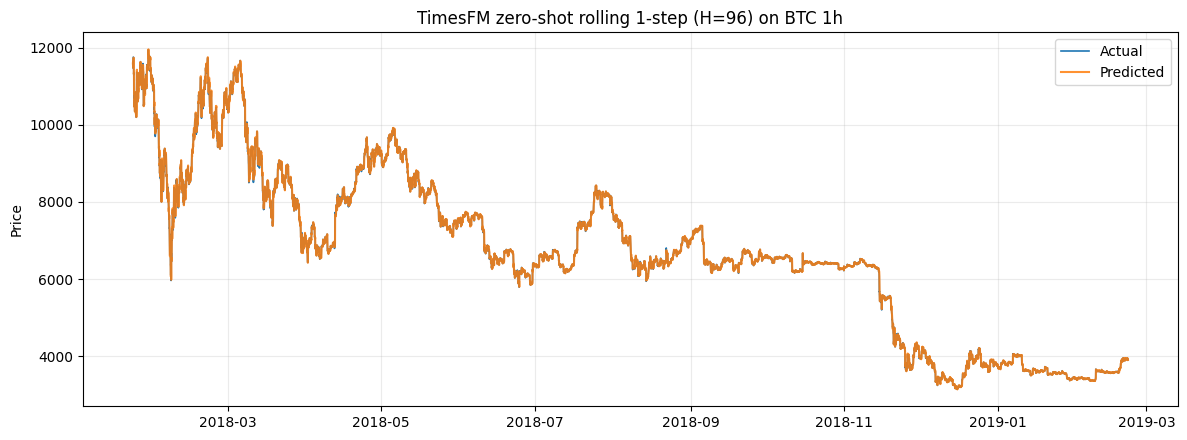

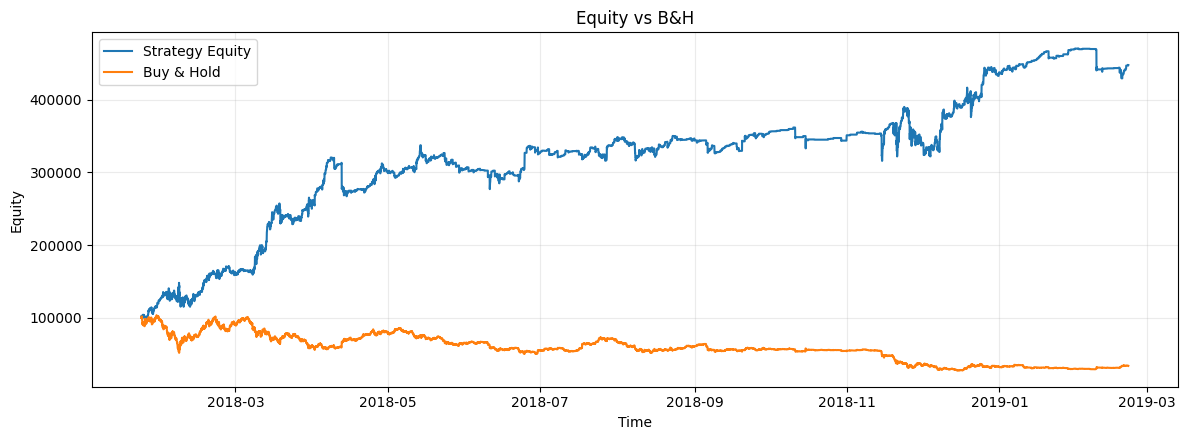

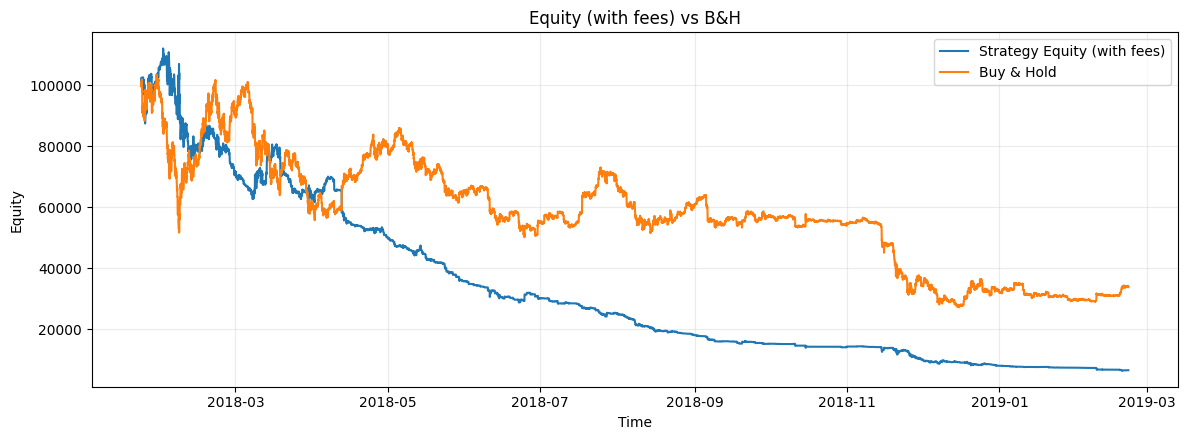

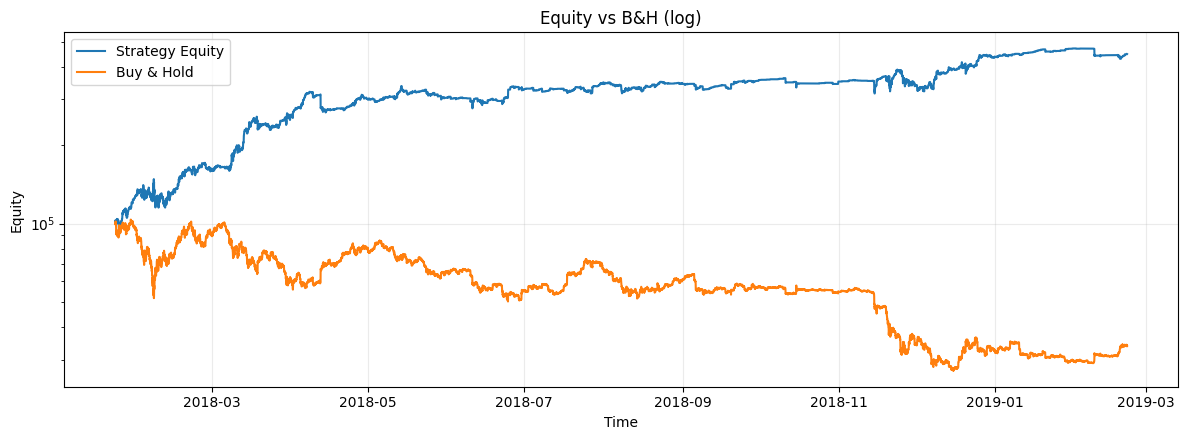

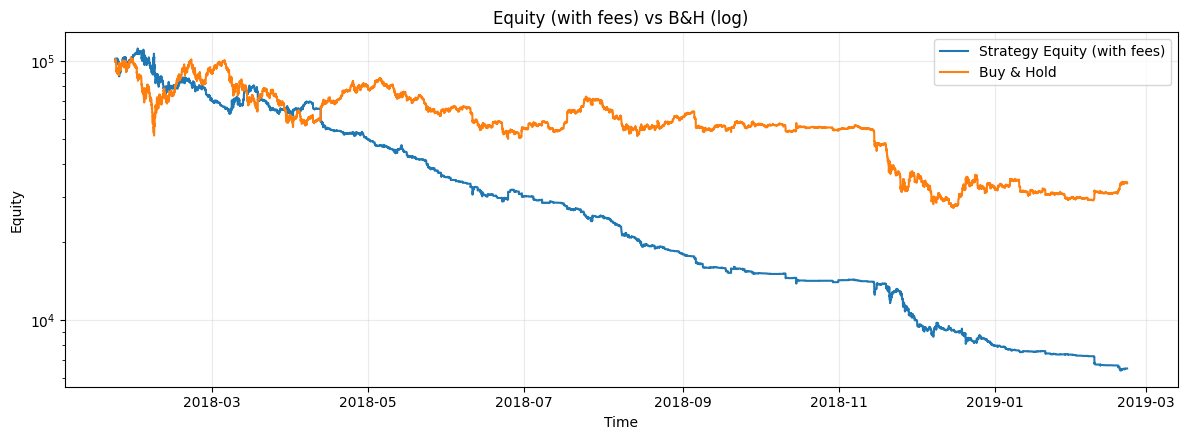

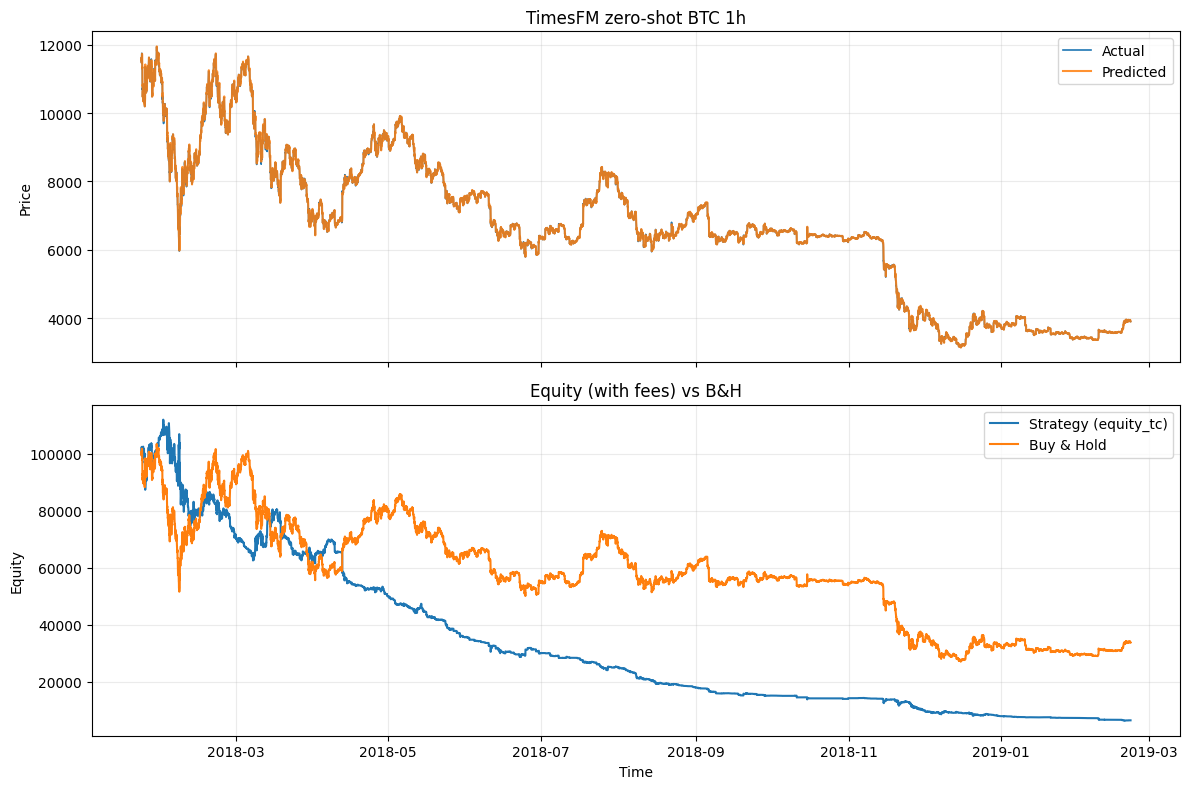

In [31]:
from utils.plotting import (
    plot_price_actual_vs_pred,
    plot_equity_no_tc_vs_bh,
    plot_equity_tc_vs_bh,
    plot_equity_no_tc_vs_bh_log,
    plot_equity_tc_vs_bh_log,
    plot_price_and_equity_panel,
)

plot_price_actual_vs_pred(df, title="TimesFM zero-shot rolling 1-step (H=96) on BTC 1h")
plot_equity_no_tc_vs_bh(df, title="Equity vs B&H")
plot_equity_tc_vs_bh(df, title="Equity (with fees) vs B&H")
plot_equity_no_tc_vs_bh_log(df, title="Equity vs B&H (log)")
plot_equity_tc_vs_bh_log(df, title="Equity (with fees) vs B&H (log)")
plot_price_and_equity_panel(
    df,
    equity_col="equity_tc",  # or "equity"
    title_price="TimesFM zero-shot BTC 1h",
    title_equity="Equity (with fees) vs B&H",
    logy_equity=False,
)